In [14]:
import numpy as np 
import os
import copy
from math import *
import matplotlib.pyplot as plt
from functools import reduce
from glob import glob

# reading in dicom files
import pydicom

# skimage image processing packages
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops

# scipy linear algebra functions 
from scipy.linalg import norm
import scipy.ndimage

# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets

# plotly 3D interactive graphs 
import plotly
from plotly.graph_objs import *

In [32]:
folder = "C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\"
folder2 = "C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\new\\"
data_paths = glob(folder + '*.dcm')
data_paths_2 = glob(folder2  + '*.dcm')
for i in data_paths_2:
    data_paths.append(i)

In [33]:
data_paths

['C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\1.dcm',
 'C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\10.dcm',
 'C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\100.dcm',
 'C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\101.dcm',
 'C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\102.dcm',
 'C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\103.dcm',
 'C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\104.dcm',
 'C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\105.dcm',
 'C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\106.dcm',
 'C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\109.dcm',
 'C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\11.dcm',
 'C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\12.dcm',
 'C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\13.dcm',
 'C:\\Users\\venka\\Desktop\\Medical_Imaging\\LearningDICOM\\14.dcm',
 'C:\\Users\\

In [34]:
def load_scan(paths):
    slices = [pydicom.read_file(path ) for path in paths]
    slices.sort(key = lambda x: int(x.InstanceNumber), reverse = True)
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [35]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [36]:
patient_dicom = load_scan(data_paths)
patient_pixels = get_pixels_hu(patient_dicom)
#sanity check
plt.imshow(patient_pixels[1], cmap=plt.cm.bone)

ValueError: all input arrays must have the same shape

In [ ]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def segment_lung_mask(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= -700, dtype=np.int8)+1
    labels = measure.label(binary_image)
 
    # Pick the pixel in the very corner to determine which label is air.
    # Improvement: Pick multiple background labels from around the  patient
    # More resistant to “trays” on which the patient lays cutting the air around the person in half
    background_label = labels[0,0,0]
 
    # Fill the air around the person
    binary_image[background_label == labels] = 2
 
    # Method of filling the lung structures (that is superior to 
    # something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
 
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
 
    # Remove other air pockets inside body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

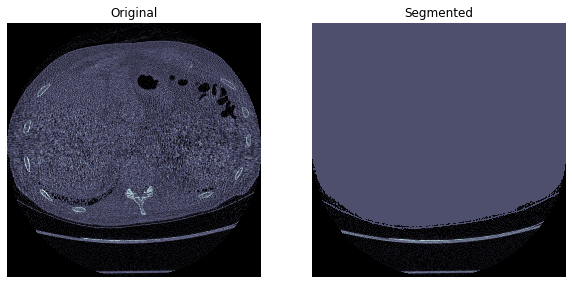

In [37]:
segmented_lungs = segment_lung_mask(patient_pixels, fill_lung_structures=False)
segmented_lungs_fill = segment_lung_mask(patient_pixels, fill_lung_structures=True)
internal_structures = segmented_lungs_fill - segmented_lungs
copied_pixels = copy.deepcopy(patient_pixels)
for i, mask in enumerate(segmented_lungs_fill): 
    get_high_vals = mask == 0
    copied_pixels[i][get_high_vals] = 0
seg_lung_pixels = copied_pixels
# sanity check
f, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].imshow(patient_pixels[3], cmap=plt.cm.bone)
ax[0].axis(False)
ax[0].set_title('Original')
ax[1].imshow(seg_lung_pixels[4], cmap=plt.cm.bone)
ax[1].axis(False)
ax[1].set_title('Segmented')
plt.show()

Lossy conversion from int16 to uint8. Range [-1024, 1977]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-1024, 2142]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-1024, 2110]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-1024, 2330]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-1024, 2100]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-1024, 1893]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-1024, 2105]. Convert image to uint8 prior to saving to suppress this warning.


Original Image Slices before processing


Lossy conversion from int16 to uint8. Range [-1024, 1944]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-1024, 1844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-1024, 1902]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-1024, 1968]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-1024, 1879]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-1024, 1724]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-1024, 1838]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-1024, 1952]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

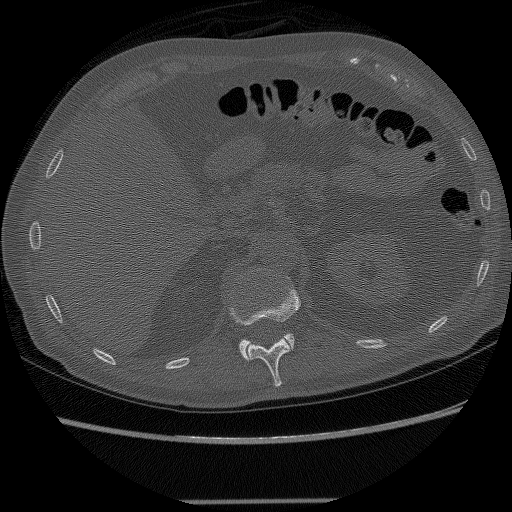

In [40]:
import imageio
from IPython import display
print('Original Image Slices before processing')
imageio.mimsave(f'./lungs.gif', patient_pixels, duration=0.1)
display.Image(f'./lungs.gif', format='png')

In [31]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from skimage import measure

def plot_3d(image, threshold=-300): 
    p = image.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()